# Google reverse image search for AVeriMaTeC claims

Small helper to pick a dev claim by its numeric ID, show the claim text and images, and send each image to Google Lens via [SerpAPI](https://serpapi.com/google-lens) for reverse image search. You can also switch to [Serper](https://serper.dev) if you have an externally reachable URL for each image.

Fill in the config cell below, set `SERPAPI_API_KEY` *or* `SERPER_API_KEY` in your environment (or hardcode it in the config), and run the notebook. Results are printed and also saved as JSON under `logs/ris_results/`.


In [1]:
from pathlib import Path
import json
import os
from typing import Dict, List

from IPython.display import display, HTML
from PIL import Image
import requests

# --- configure here ---
DATA_ROOT = Path("/mnt/data/factcheck/averimatec")
CLAIM_ID = 0
INCLUDE_QUESTION_IMAGES = False
SEARCH_BACKEND = "serper"  # serpapi | serper
SERPAPI_KEY = os.environ.get("SERPAPI_API_KEY", "")  # put your key here if you prefer
SERPER_KEY = os.environ.get("SERPER_API_KEY", "")  # Serper API key
SPLIT = "test"
SERPER_IMAGE_BASE_URL = os.environ.get("SERPER_IMAGE_BASE_URL", f"https://fcheck.fel.cvut.cz/images/averimatec")  # e.g., https://your-bucket/images
OUTPUT_DIR = Path("logs/ris_results")
# -----------------------

In [2]:
print(len(SERPER_KEY)), print(len(os.environ.get("FIRECRAWL_API_KEY", "")))

40
35


(None, None)

In [3]:
def load_claim(split: str, claim_id: int) -> Dict:
    json_path = DATA_ROOT / f"{split}.json"
    if not json_path.exists():
        raise FileNotFoundError(f"Missing split file at {json_path}")
    with open(json_path, "r") as f:
        data = json.load(f)
    if claim_id < 0 or claim_id >= len(data):
        raise IndexError(f"Claim ID {claim_id} is out of range (0-{len(data)-1})")
    claim = data[claim_id].copy()
    claim["claim_id"] = claim_id
    return claim


def collect_images(claim: Dict, include_question_images: bool = True) -> List[Path]:
    paths = [DATA_ROOT / "images" / name for name in claim.get("claim_images", [])]
    if include_question_images:
        for q in claim.get("questions", []):
            for name in q.get("input_images", []):
                paths.append(DATA_ROOT / "images" / name)
    seen = set()
    unique_paths = []
    for p in paths:
        if p not in seen:
            unique_paths.append(p)
            seen.add(p)
    return unique_paths


claim = load_claim(SPLIT, CLAIM_ID)
image_paths = collect_images(claim, INCLUDE_QUESTION_IMAGES)

display(HTML(f"""
<h3>Claim {claim['claim_id']}</h3>
<p><b>claim_text:</b> {claim.get('claim_text', '—')}</p>
<p><b>images found:</b> {len(image_paths)} ({'with' if INCLUDE_QUESTION_IMAGES else 'without'} question input images)</p>
"""))


Showing 6787a64be2f02e5f49815ef5#CLAIM#0.jpg


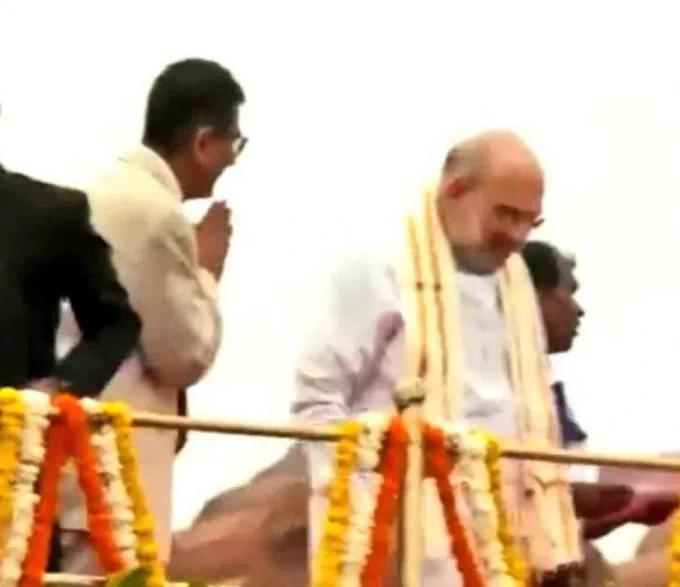

In [4]:
for img_path in image_paths:
    if not img_path.exists():
        print(f"Missing file: {img_path}")
        continue
    print(f"Showing {img_path.name}")
    display(Image.open(img_path))


In [5]:
def google_reverse_image_search(image_path: Path, api_key: str = SERPAPI_KEY, timeout: int = 60) -> Dict:
    """Send one image to Google Lens via SerpAPI and return the parsed JSON response."""
    if not api_key:
        raise RuntimeError("Missing SERPAPI_API_KEY. Set the env var or populate SERPAPI_KEY in the config cell.")
    if not image_path.exists():
        raise FileNotFoundError(f"Image not found: {image_path}")
    files = {"file": (image_path.name, open(image_path, "rb"), "image/jpeg")}
    params = {
        "engine": "google_lens",
        "api_key": api_key,
        "hl": "en",
    }
    resp = requests.post("https://serpapi.com/search.json", params=params, files=files, timeout=timeout)
    resp.raise_for_status()
    return resp.json()


def serper_reverse_image_search(image_url: str, api_key: str = SERPER_KEY, timeout: int = 60) -> Dict:
    """Use Serper Google Lens with an externally reachable image URL."""
    if not api_key:
        raise RuntimeError("Missing SERPER_API_KEY. Set the env var or populate SERPER_KEY in the config cell.")
    headers = {
        "X-API-KEY": api_key,
        "Content-Type": "application/json",
    }
    payload = {"url": image_url, "gl": "gb"}
    # print payload for debugging
    print("Serper payload:", payload)
    resp = requests.post("https://google.serper.dev/lens", headers=headers, json=payload, timeout=timeout)
    resp.raise_for_status()
    return resp.json()


def make_serper_url(img_path: Path) -> str:
    if SERPER_IMAGE_BASE_URL:
        return f"{SERPER_IMAGE_BASE_URL.rstrip('/')}/{img_path.name}".replace("#", "_")
    raise RuntimeError("Serper needs an externally reachable image URL. Set SERPER_IMAGE_BASE_URL to where the images are hosted (e.g., an S3 bucket).")


def reverse_image_search(img_path: Path) -> Dict:
    if SEARCH_BACKEND == "serpapi":
        return google_reverse_image_search(img_path)
    if SEARCH_BACKEND == "serper":
        url = make_serper_url(img_path)
        return serper_reverse_image_search(url)
    raise ValueError(f"Unknown SEARCH_BACKEND: {SEARCH_BACKEND}")


In [7]:
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)
all_results = []

for img_path in image_paths:
    if not img_path.exists():
        continue
    print(f"\nRunning {SEARCH_BACKEND} reverse image search for {img_path.name}...")
    result = reverse_image_search(img_path)
    all_results.append({"image": img_path.name, "result": result})

    visuals = (result.get("visual_matches") or result.get("images_results") or [])[:3]
    organic = (result.get("organic_results") or result.get("organic") or [])[:3]
    print(f"Top {len(visuals)} visual matches:")
    for idx, match in enumerate(visuals, start=1):
        title = match.get("title") or match.get("link") or "(no title)"
        print(f"  {idx}. {title}")
    print(f"Top {len(organic)} web results:")
    for idx, hit in enumerate(organic, start=1):
        title = hit.get("title") or hit.get("link") or "(no title)"
        print(f"  {idx}. {title}")

save_path = OUTPUT_DIR / f"claim_{claim['claim_id']}_ris.json"
with open(save_path, "w") as f:
    json.dump({"claim": claim, "results": all_results}, f, indent=2)
print(f"\nSaved raw responses to {save_path}")



Running serper reverse image search for 6787a64be2f02e5f49815ef5#CLAIM#0.jpg...
Serper payload: {'url': 'https://fcheck.fel.cvut.cz/images/averimatec/6787a64be2f02e5f49815ef5_CLAIM_0.jpg', 'gl': 'gb'}
Top 0 visual matches:
Top 3 web results:
  1. Khatta- meetha rishta- Judiciary- Government.
  2. 2000 Terrorist Attack On Red Fort: The Day That Strained India-Pakistan Relations
  3. dy chandrachud," - Results on X | Live Posts & Updates

Saved raw responses to logs/ris_results/claim_0_ris.json


In [6]:
image_search_all = []
for claim_id in range(352):
    perclaim_results = []
    for image in collect_images(load_claim(SPLIT, claim_id), INCLUDE_QUESTION_IMAGES):
        print(f"\nRunning {SEARCH_BACKEND} reverse image search for claim {claim_id}")
        result = reverse_image_search(image)
        perclaim_results.append({"claim_id": claim_id, "image": image.name, "result": result})
    image_search_all.append(perclaim_results)
    json.dump(image_search_all, open(OUTPUT_DIR / f"{SPLIT}.json", "w"), indent=2, ensure_ascii=False)


Running serper reverse image search for claim 0
Serper payload: {'url': 'https://fcheck.fel.cvut.cz/images/averimatec/6787a64be2f02e5f49815ef5_CLAIM_0.jpg', 'gl': 'gb'}

Running serper reverse image search for claim 1
Serper payload: {'url': 'https://fcheck.fel.cvut.cz/images/averimatec/6787b063e2f02e5f49816628_CLAIM_0.jpg', 'gl': 'gb'}

Running serper reverse image search for claim 2
Serper payload: {'url': 'https://fcheck.fel.cvut.cz/images/averimatec/6787bb68e2f02e5f498179d1_CLAIM_0.jpg', 'gl': 'gb'}


KeyboardInterrupt: 

In [7]:
try:
    from htmldate import find_date
    from markitdown import MarkItDown
except ImportError:

    from htmldate import find_date
    from markitdown import MarkItDown

from datetime import datetime

# Set the RIS file to inspect: aggregated "SPLIT.json" or a single claim file.
RIS_JSON_PATH = OUTPUT_DIR / f"{SPLIT}.json"  # or OUTPUT_DIR / f"claim_{claim["claim_id"]}_ris.json"
SCRAPE_OUTPUT_PATH = OUTPUT_DIR / f"{SPLIT}_scraped_links.json"


def normalize_date(date_str):
    if not date_str:
        return None
    cleaned = str(date_str).strip()
    try:
        return datetime.fromisoformat(cleaned.replace("Z", "+00:00")).date()
    except Exception:
        try:
            return datetime.strptime(cleaned[:10], "%Y-%m-%d").date()
        except Exception:
            return None


def iter_ris_entries(payload):
    if isinstance(payload, dict) and "results" in payload:
        cid = payload.get("claim", {}).get("claim_id")
        for res in payload["results"]:
            yield cid, res
    elif isinstance(payload, list):
        for block in payload:
            if isinstance(block, list):
                for res in block:
                    yield res.get("claim_id"), res
            elif isinstance(block, dict):
                cid = block.get("claim_id")
                if "results" in block:
                    for res in block["results"]:
                        yield cid, res
                else:
                    yield cid, block
    else:
        raise ValueError("Unsupported RIS JSON shape")


def extract_links(ris_result):
    links = set()
    for key in ("organic_results", "organic", "images_results", "visual_matches"):
        for item in ris_result.get(key, []) or []:
            link = item.get("link")
            if link:
                links.add(link)
    return sorted(links)


def find_page_date(url):
    try:
        raw = find_date(url, original_date=True, outputformat="%Y-%m-%d")
    except Exception:
        return None
    return normalize_date(raw)

In [ ]:
from firecrawl import Firecrawl
ris_payload = json.load(open(RIS_JSON_PATH, "r"))
firecrawl = Firecrawl()
scraped_records = []
for cid, entry in iter_ris_entries(ris_payload):
    claim_obj = load_claim(SPLIT, cid) if cid is not None else claim
    claim_dt = normalize_date(claim_obj.get("date"))
    if not claim_dt:
        print(f"Skipping claim {cid}: missing claim date")
        continue
    print(f"Processing claim {cid} dated {claim_dt.isoformat()}...")
    ris_result = entry.get("result", entry)
    for url in extract_links(ris_result):
        page_dt = find_page_date(url)
        if not page_dt or page_dt > claim_dt:
            continue
        scraped = {
            "claim_id": claim_obj.get("claim_id", cid),
            "claim_date": claim_dt.isoformat(),
            "image": entry.get("image"),
            "url": url,
            "page_date": page_dt.isoformat(),
        }
        try:
            doc = firecrawl.scrape(
                url,
                formats=["markdown", "html"],
            )

            doc.metadata = dict(doc.metadata)
            scraped["content"] = dict(doc)
        except Exception as exc:
            scraped["error"] = str(exc)
            print(f"Error scraping {url}: {exc}")
        scraped_records.append(scraped)

    with open(SCRAPE_OUTPUT_PATH, "w") as f:
        json.dump(scraped_records, f, indent=2, ensure_ascii=False)

print(f"Saved {len(scraped_records)} scraped pages to {SCRAPE_OUTPUT_PATH}")

Processing claim 0 dated 2023-08-15...
Error scraping https://www.facebook.com/ALOKJIPARIVAROFFICIAL/: Website Not Supported: Failed to scrape. This website is not currently supported. If you are part of an enterprise, please reach out to help@firecrawl.com to discuss the possibility of getting it activated on your account. - No additional error details provided.
Error scraping https://www.facebook.com/jyoti.joshi.35325/videos/: Website Not Supported: Failed to scrape. This website is not currently supported. If you are part of an enterprise, please reach out to help@firecrawl.com to discuss the possibility of getting it activated on your account. - No additional error details provided.
Error scraping https://www.facebook.com/photo.php?fbid=682330717274551&id=100064928850532&set=a.357363036437989: Website Not Supported: Failed to scrape. This website is not currently supported. If you are part of an enterprise, please reach out to help@firecrawl.com to discuss the possibility of gettin

In [ ]:
for cid, entry in iter_ris_entries(ris_payload):
    if 142 >= cid:
        continue
    claim_obj = load_claim(SPLIT, cid) if cid is not None else claim
    claim_dt = normalize_date(claim_obj.get("date"))
    if not claim_dt:
        print(f"Skipping claim {cid}: missing claim date")
        continue
    print(f"Processing claim {cid} dated {claim_dt.isoformat()}...")
    per_img = 0
    ris_result = entry.get("result", entry)
    for url in extract_links(ris_result):
        if per_img >= 10:
            break
        page_dt = find_page_date(url)
        if not page_dt or page_dt > claim_dt:
            continue
        scraped = {
            "claim_id": claim_obj.get("claim_id", cid),
            "claim_date": claim_dt.isoformat(),
            "image": entry.get("image"),
            "url": url,
            "page_date": page_dt.isoformat(),
        }
        try:
            doc = firecrawl.scrape(
                url,
                formats=["markdown", "html"],
            )

            doc.metadata = dict(doc.metadata)
            scraped["content"] = dict(doc)
            per_img += 1
        except Exception as exc:
            scraped["error"] = str(exc)
            print(f"Error scraping {url}: {exc}")
        scraped_records.append(scraped)

    with open(SCRAPE_OUTPUT_PATH, "w") as f:
        json.dump(scraped_records, f, indent=2, ensure_ascii=False)

print(f"Saved {len(scraped_records)} scraped pages to {SCRAPE_OUTPUT_PATH}")

Processing claim 143 dated 2023-10-07...
Error scraping https://www.facebook.com/groups/843330955712848/posts/9708301912548997/: Website Not Supported: Failed to scrape. This website is not currently supported. If you are part of an enterprise, please reach out to help@firecrawl.com to discuss the possibility of getting it activated on your account. - No additional error details provided.
Processing claim 144 dated 2023-08-08...
Error scraping https://www.facebook.com/photo.php?fbid=588331246836063&id=100069775777673&set=a.477443971258125: Website Not Supported: Failed to scrape. This website is not currently supported. If you are part of an enterprise, please reach out to help@firecrawl.com to discuss the possibility of getting it activated on your account. - No additional error details provided.
Processing claim 144 dated 2023-08-08...
Error scraping https://www.facebook.com/100063943989340/posts/brentfordfcs-nigeria-defender-benjamin-fredrick-set-to-miss-afcon2025-with-a-kne/1316167